In [5]:
dump_env = False  # create backup copies of the Python kernel
if dump_env: import dill

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten #, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%run plot.py


### Read data

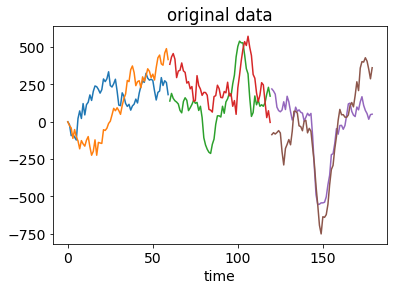

data:  10000


In [7]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5 }
locals().update(param)
x = x.reshape((N,L,dim))
Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

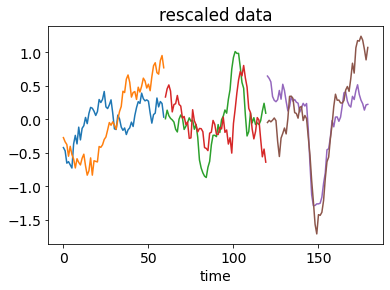

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [8]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")


x_train = x_train.reshape(x_train.shape[0], L, 2)
x_val =  x_val.reshape(x_val.shape[0], L, 2)
input_shape = (L, 2)

## Convolutional NN

In [9]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)


In [10]:
def create_DNN_GridSearch(activation, dropout_rate, reg_lambda,reg_type):
    if reg_type == "Lasso" :
        reg = tf.keras.regularizers.l1(reg_lambda)
    elif reg_type == "Ridge" :
        reg = tf.keras.regularizers.l2(reg_lambda)
    else:
        reg = tf.keras.regularizers.l1_l2(reg_lambda)
    
    NCONV = 1
    NF = 5
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                        seed=None)
    model = Sequential()
    
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation="relu", 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(12, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_class,activation="sigmoid"))
    
    return model
    
def compile_model(optimizer="Adam", activation = "relu", dropout_rate = 0.2, reg_lambda = 0.002, reg_type = "Lasso")  :
    # create the mode
    model=create_DNN_GridSearch(activation, dropout_rate, reg_lambda,reg_type)
    # compile the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
# # call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ["Adam", "RMSProp"]
activation = ['relu',"tanh","softplus","softsign"]
dropout_rate = [0.0,0.1,0.2,0.3,0.4]
reg_lambda = [0,2*10**-6, 2*10**-5,2*10**-4,2*10**-3,2*10**-2, 2*10**-1, 2, 2*10**1]
reg_type = ["Lasso", "Ridge","Combined"]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate, reg_lambda = reg_lambda, reg_type=reg_type)

In [12]:
## DO THE GRIDSEARCH

# call scikit grid search module
#grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
#grid_result = grid.fit(x_train,y_train, epochs=200, batch_size = 10, shuffle = True,verbose=0)# epochs and batch sizes have to be increased, but we need a powerful computer

In [13]:
# summarize results
#print("best %f%% using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#grid_results_sorted = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)

#print('\n======= all results ======')
#for mean, stdev, param in grid_results_sorted: #sorted( grid_results_sorted , key=lambda x: x[2]['optimizer'], reverse=True):
#    print("%f (+-%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

In [16]:
## ... OR LOAD THE RESULTS
import json

with open('params.json', 'r') as f:
    params = json.load(f)

means = np.load('means.npy')
stds = np.load('stds.npy')
grid_results_sorted = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)

## Awnser to part 3.0: Gridsearch Results

A Gridsearch was conducted with different values of lambda: 
$$
lambda = [0,2*10^{-6}, 2*10^{-5},2*10^{-4},2*10^{-3},2*10^{-2}, 2*10^{-1}, 2]
$$
And the 3 different regulatization classes:
$$
type = [Lasso, Ridge, Combined]
$$

The best parameters were then chose and used to train a model.


In [34]:
chosen_params = {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'Adam', 'reg_lambda': 0.02, 'reg_type': 'Ridge'} # paste here the model to use

model = compile_model(**chosen_params)
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
fit = model.fit(x_train, y_train,
                epochs = 400, batch_size = 50,
                validation_data = (x_val, y_val),
                verbose = 0)

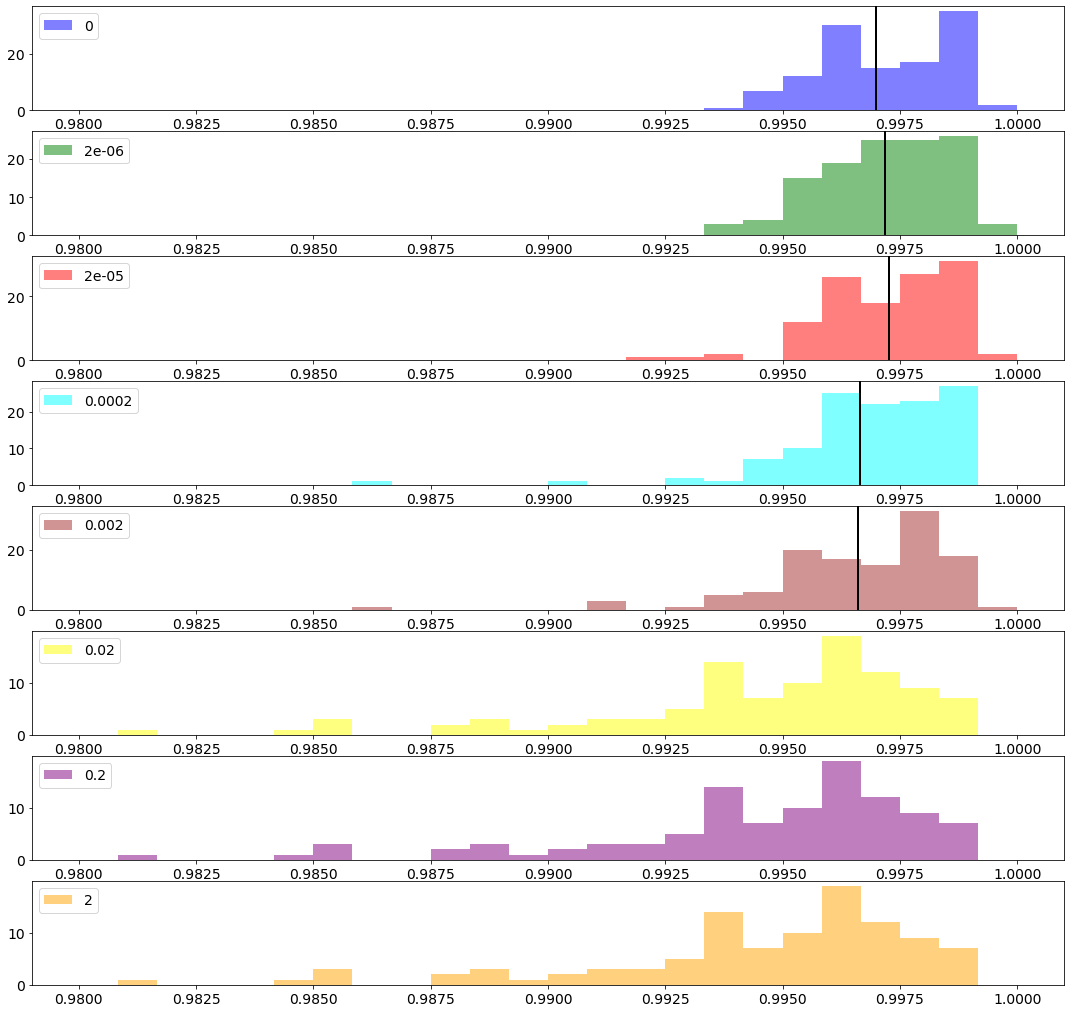

In [26]:
import numpy as np
import matplotlib.pyplot as plt

layerscores = [[] for i in range(len(reg_lambda))]

for i in range(len(reg_lambda)):
    layerscores[i] = list(list(zip(*[d for d in grid_results_sorted if d[2]['reg_lambda']==reg_lambda[i]]))[0])

data1 = np.array(layerscores[0])
data2 = np.array(layerscores[1])
data3 = np.array(layerscores[2])
data4 = np.array(layerscores[3])
data5 = np.array(layerscores[4])
data6 = np.array(layerscores[5])
data7 = np.array(layerscores[6])
data8 = np.array(layerscores[7])

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(8)
fig.set_size_inches(18.5, 18)
bins = np.linspace(0.98, 1,25)
ax0.hist(data1, bins=bins, color='blue', label=str(reg_lambda[0]) ,
        alpha=0.5, histtype='stepfilled')
ax1.hist(data2, bins=bins, color='green', label=str(reg_lambda[1]),
        alpha=0.5, histtype='stepfilled')
ax2.hist(data3, bins=bins, color='red', label=str(reg_lambda[2]),
        alpha=0.5, histtype='stepfilled')
ax3.hist(data4, bins=bins, color='cyan', label=str(reg_lambda[3]),
        alpha=0.5, histtype='stepfilled')
ax4.hist(data5, bins=bins, color='brown', label=str(reg_lambda[4]),
        alpha=0.5, histtype='stepfilled')
ax5.hist(data6, bins=bins, color='yellow', label=str(reg_lambda[5]),
        alpha=0.5, histtype='stepfilled')
ax6.hist(data6, bins=bins, color='purple', label=str(reg_lambda[6]),
        alpha=0.5, histtype='stepfilled')
ax7.hist(data6, bins=bins, color='orange', label=str(reg_lambda[7]),
        alpha=0.5, histtype='stepfilled')

##This lines indicate the means
ax0.axvline(np.nanmean(data1), color='black', linewidth=2)
ax1.axvline(np.nanmean(data2), color='black', linewidth=2)
ax2.axvline(np.nanmean(data3), color='black', linewidth=2)
ax3.axvline(np.nanmean(data4), color='black', linewidth=2)
ax4.axvline(np.nanmean(data5), color='black', linewidth=2)
#ax5.axvline(np.nanmean(data6), color='black', linewidth=2)
#ax6.axvline(np.nanmean(data7), color='black', linewidth=2)
#ax7.axvline(np.nanmean(data8), color='black', linewidth=2)


ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
ax5.legend(loc='upper left')
ax6.legend(loc='upper left')
ax7.legend(loc='upper left')



plt.show()

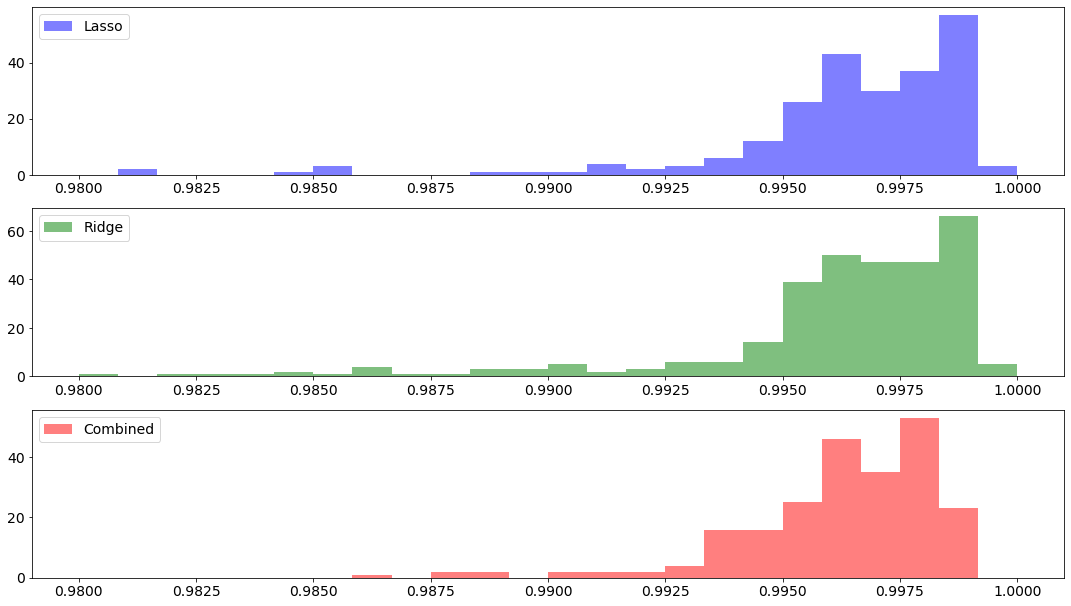

In [23]:
layerscores = [[] for i in range(len(reg_type))]

for i in range(len(reg_type)):
    layerscores[i] = list(list(zip(*[d for d in grid_results_sorted if d[2]['reg_type']==reg_type[i]]))[0])

data1 = np.array(layerscores[0])
data2 = np.array(layerscores[1])
data3 = np.array(layerscores[2])
#data4 = np.array(layerscores[3])
#data5 = np.array(layerscores[4])
#data6 = np.array(layerscores[5])

fig, (ax0,ax1,ax2) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)
bins = np.linspace(0.98, 1,25)
ax0.hist(data1, bins=bins, color='blue', label=reg_type[0],
        alpha=0.5, histtype='stepfilled')
ax1.hist(data2, bins=bins, color='green', label=reg_type[1],
        alpha=0.5, histtype='stepfilled')
ax2.hist(data3, bins=bins, color='red', label=reg_type[2],
        alpha=0.5, histtype='stepfilled')
#ax.hist(data4, bins=bins, color='cyan', label='4 Layers',
#        alpha=0.5, histtype='stepfilled')
#ax.hist(data5, bins=bins, color='brown', label='5 Layers',
#        alpha=0.5, histtype='stepfilled')
#ax.hist(data6, bins=bins, color='yellow', label='6 Layers',
#        alpha=0.5, histtype='stepfilled')

##This lines indicate the means
#ax0.axvline(np.nanmean(data1), color='blue', linewidth=2)
#ax1.axvline(np.nanmean(data3), color='green', linewidth=2)
#ax2.axvline(np.nanmean(data2), color='red', linewidth=2)
#ax.axvline(data4.mean(), color='cyan', linewidth=2)
#ax.axvline(data5.mean(), color='brown', linewidth=2)
#ax.axvline(data6.mean(), color='yellow', linewidth=2)


ax0.legend(loc='upper left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.show()

In [20]:
if dump_env: dill.dump_session('checkpoint_3_0.db')

In [27]:
print(np.nanmean(data1))
print(np.nanmean(data2))
print(np.nanmean(data3))
print(np.nanmean(data4))
print(np.nanmean(data5))
print(np.nanmean(data6))
print(np.nanmean(data7))
print(np.nanmean(data8))

0.9969885443647702
0.9971791684627533
0.9972687526295583
0.9966395838807026
0.9966083350280921
0.9112208357080818
0.6404979172473152
0.5229614578187466


## Awnser to part 3.1: Values of lambda and regularizations

|      	| Lasso    	| Ridge    	| Combined 	|   	|
|------	|----------	|----------	|----------	|---	|
| Mean 	| 0.776875 	| 0.957768 	| 0.775256 	|   	|


|   λ   | 0      	| 2e-6    	| 2e-5   	| 2e-4   	| 2e-3   	| 2e-2   	| 2e-1      | 2	        |   	|
|------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|----------	|---	|
| Mean 	| 0.996988 	| 0.997179 	| 0.997268 	|  0.996639	|  0.996608	|  0.911220	|  0.640497	|  0.522961	|   	|


In the first histogram, the black line represent the mean of the scores found for a given lambda. It can be noted that the bins approaching the left part of the histogram are being occupied in greater amount by the higher regularization lambda. The last values of the means are heavily affected by results that were negatively affected by big regularization and are close to 0.33(random choice). There is also noted that Ridge regularization is more resistant to high lambda while lasso and combined have their filters put to zero in numerous ocasions.



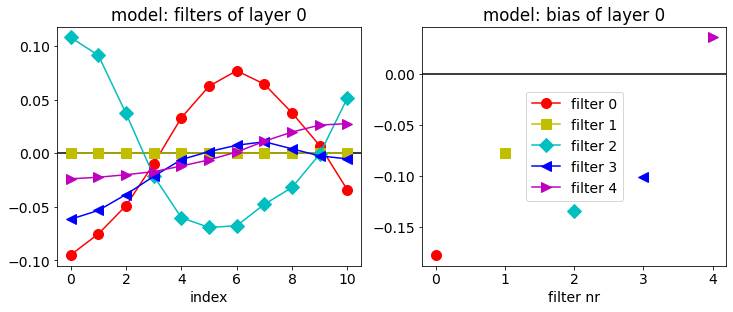

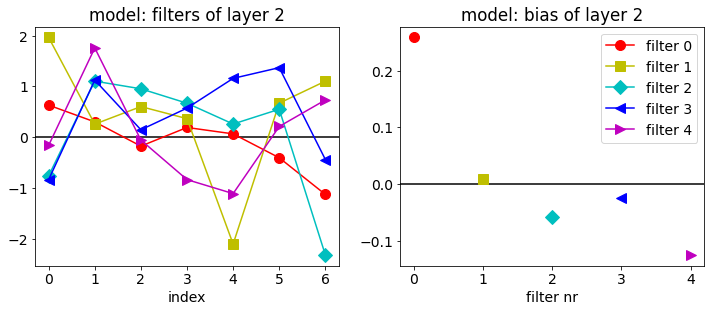

In [36]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [ ]:
if dump_env: dill.dump_session('checkpoint_3_1.db')

## Awnser to part 3.2: Weight visualization

It can be appreciated, from the above graphs, that some filter coefficients are put to 0 by the regulatization procedure. It happens because the network learns to recognize that a concave and a convex shape are being introduced to the data samples.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d991341-85e0-460c-ac0b-888d6f039546' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>